### 探索有趣的问题
- 你知道国内（不含港澳台）目前一共有多少家上市公司吗？  
- 上市公司主要分布在哪些地方（省市）？
- 上市公司的资产情况如何？
- 目前上市公司的市盈率/市净率情况如何？
- 资产规模最大/小的十家上市公司有哪些，具体规模多少？
- 上市公司目前经营情况如何？（收入同比、利润同比、毛利率、净利润率）

### 获取数据
主要使用tushare包获取A股所有上市公司截至目前（2018年11月26日）的基本面数据，分析相关特征和可视化，挖掘数据背后隐藏的信息。

In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
from scipy import stats
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [2]:
#调取股票基本面数据和行情数据
#基本面数据
basics_data=ts.get_stock_basics()
#保存数据到本地
#basics_data.to_csv("basics_data.csv",encoding='gbk')

In [3]:
basics_data.shape

(3569, 22)

#### 数据特征  
code,代码；
name,名称；
industry,细分行业；
area,地区；
pe,市盈率；
outstanding,流通股本；
totals,总股本(万)；
totalAssets,总资产(万)；
liquidAssets,流动资产；
fixedAssets,固定资产；
reserved,公积金；
reservedPerShare,每股公积金；
eps,每股收益；
bvps,每股净资；
pb,市净率；
timeToMarket,上市日期；
undp 未分配利润；
perundp 每股未分配；
rev 收入同比（%）；
profit 利润同比（%）；
gpr 毛利率（%）；
npr 净利润率（%）；
holders_num 股东人数

In [4]:
#查看前三行前8列数据
basics_data.iloc[:3,:8]

,name,industry,area,pe,outstanding,totals,totalAssets,liquidAssets
code,,,,,,,,
300752,N隆利,元器件,深圳,11.90,0.18,0.73,103243.88,87401.40
002089,新 海 宜,通信设备,江苏,39.70,9.36,13.75,462289.09,186343.20
002108,沧州明珠,塑料,河北,15.67,14.18,14.18,509844.59,239589.77


#### 上市公司分布

In [5]:
#使用groupby对上市公司归属地进行汇总，统计每个省份（直辖市）上市公司的总数
area=basics_data.groupby('area')['name'].count()
#从大到小进行排序，取出前十名
area.sort_values(ascending=False)[:10]

area
浙江    431
江苏    400
北京    316
广东    304
上海    284
深圳    283
山东    195
福建    131
四川    120
湖南    104
Name: name, dtype: int64

这里发现一个bug，统计数据把广东和深圳分开了，怪不得广东排在第四呢。实际上，广东（“广东304”+“深圳283”）一共有587家上市公司，是全国在A股内上市公司最多的省份，占比高达16.47%。截至目前，深圳有283家上市公司，与上海持平，在广东占比高达48.21%，坐拥半壁江山，可见深圳的实力很强大。

In [6]:
#将“广东”与深圳数据合并成新的广东
area['广东']=area['广东']+area['深圳']
area.drop(['深圳'],inplace=True)
area.sort_values(ascending=False)[:10]

area
广东    587
浙江    431
江苏    400
北京    316
上海    284
山东    195
福建    131
四川    120
湖南    104
安徽    103
Name: name, dtype: int64

#### 中国上市公司分布地图
由于经济区域发展的不平衡，上市公司主要集中在沿海地区，那么如何在一张中国地图上反映这一情况呢？  
这里安利一下百度的Python开源画图工具pyecharts，可以画出很酷炫的动态图。  
下面使用pyecharts将各省（直辖市）上市公司汇总数映射到中国地图上。

首先，安装中国省市地图包 ：   
pip install echarts-countries-pypkg  
pip install echarts-china-provinces-pypkg   
pip install echarts-china-cities-pypkg   
pip install echarts-china-counties-pypkg   
pip install echarts-china-misc-pypkg  
其次，安装pyecharts：  
pip install pyecharts==0.1.9.4  
后面那个版本号要加上，不然装好了import也会报错。

需要安装html5的库，不然显示不了 pyecharts 的图  
【Anaconda Prompt命令行】conda install -c anaconda html5lib

【Anaconda Prompt命令行】pip install echarts-themes-pypkg

In [7]:
#导入作图包
from pyecharts import Map

In [8]:
# 将数据转化为字典，不转也可以
d =dict(area)
province=list(d.keys())
value=list(d.values())

In [30]:
#maptype='china' 只显示全国直辖市和省级
#数据只能是省名和直辖市的名称
map = Map("中国上市公司分布", title_color="#fff",
          title_pos="center", width=900, 
          height=500,background_color='#404a59')
map.add("", province, value,visual_range=[min(value),max(value)], 
       is_label_show=True,maptype='china',is_visualmap=True, 
        is_map_symbol_show=False,label_pos="center",fontsize=8,
        visual_text_color='#000')
#map.render(path="中国上市公司分布.html")
#到所在的目录查找文件：中国上市公司分布.html
map

画出的是动态的中国地图（html格式），html文件使用浏览器打开，鼠标停留就能显示省市名称和上市公司个数。

下面使用柱状图对排名前十的省市进行可视化。

In [31]:
#定义显示数值标签函数
def autolabel(fig):
    for f in fig:
        height = f.get_height()
        plt.text(f.get_x()+f.get_width()/2.-0.2, 
                 1.03*height, '%s' % int(height))   

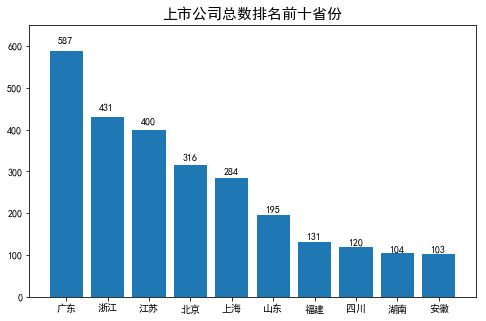

In [32]:
area_top=area.sort_values(ascending=False)[:10]
d=dict(area_top)
plt.figure(figsize=(8,5))
fig=plt.bar(d.keys(), d.values())
autolabel(fig)   
plt.title("上市公司总数排名前十省份",fontsize=15)
plt.ylim(0,650)
plt.show()
#台湾和港澳台的没有统计进来

In [33]:
#考察上市公司分布的集中度情况
top5=(area.sort_values(ascending=False)[:5].sum()/area.sum())*100
top10=(area.sort_values(ascending=False)[:10].sum()/area.sum())*100
print("前五个省份上市公司总数占比{:.2f}%".format(top5))
print("前十个省份上市公司总数占比{:.2f}%".format(top10))

前五个省份上市公司总数占比56.57%
前十个省份上市公司总数占比74.88%


显然，广东省是国内A股上市公司最多的省份，截至2018年11月26日，上市公司数目为587个，是排名第十安徽的5.8倍。前五个省份（直辖市）加起来一共有2017家上市公司，占全部上市公司总数的56.56%；前十个省份上市公司总数占比74.87%，可见上市公司分布的集中度比较高，主要集聚在广东、浙江、江苏、北京、上海、山东和福建沿海地区。

如果将某个省（直辖市）所有上市公司的资产加总，这个排名是否不变呢？

In [34]:
#对上市公司的总资产根据地区分类汇总
totalAssets=basics_data.groupby('area')['totalAssets'].sum()
#单位转换为万亿元，保留四位小数
totalAssets=round(totalAssets/10**8,4) 
#排序选出前十大省市
totalAssets.sort_values(ascending=False)[:10]

area
北京    140.0676
上海     26.3393
深圳     23.1389
福建      8.4503
江苏      7.7169
浙江      5.2406
广东      4.5403
山东      3.3713
四川      1.7313
河北      1.6175
Name: totalAssets, dtype: float64

同样，深圳和广东的数据是分开统计的，但有意思的是，深圳上市公司的总资产是广东（除深圳）的5倍多（amazing！）。此外，前文数据显示，北京一共有316家上市公司，全国排第四位，但其上市公司资产总和却达到140万亿元，远远超过第二名的广东（23.1+4.5=27.6亿)，是排名第9湖北的93倍，是排名最后宁夏（658亿元）的212倍，区域发展的不平衡可见一斑，财富的分布往往是遵循幂律分布的（马太效应或二八法则会不断自我强化）。北京不仅是政治和文化中心，还是经济中心，上市公司里的大型国企、央企和金融机构（如四大行）总部基本上都在北京；广东民营经济相对发达，尤其是深圳、佛山和东莞，规模不大的中小民营企业上市较多。

In [35]:
#把深圳数据合并到广东
totalAssets['广东']=totalAssets['广东']+totalAssets['深圳']
totalAssets.drop(['深圳'],inplace=True)
#查看前十名
totalAssets.sort_values(ascending=False)[:10]

area
北京    140.0676
广东     27.6792
上海     26.3393
福建      8.4503
江苏      7.7169
浙江      5.2406
山东      3.3713
四川      1.7313
河北      1.6175
湖北      1.5105
Name: totalAssets, dtype: float64

In [37]:
#地图可视化
#d =dict(totalAssets)
#x=list(d.keys())
#y=list(d.values())

x=totalAssets.index
y=totalAssets.values

map = Map("上市公司总资产分布图", title_color="#fff",
          title_pos="center", width=800, height=500,
          background_color='#404a59')
map.add("", x, y, maptype='china',is_visualmap=True,
        is_map_symbol_show=False,
        is_label_show=True,visual_range=[min(y),max(y)],
        visual_text_color='#000')
#map.render(path="上市公司总资产分布图.html")
map

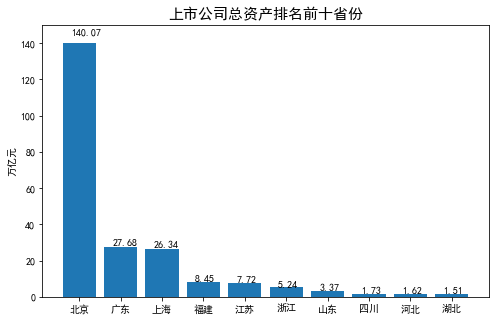

In [16]:
def autolabel(fig):
    for f in fig:
        height = f.get_height()
        plt.text(f.get_x()+f.get_width()/2.-0.2, 
                 1.03*height, '%s' % round(float(height),2))   

TA_top=totalAssets.sort_values(ascending=False)[:10]
d=dict(TA_top)
plt.figure(figsize=(8,5))
fig=plt.bar(d.keys(), d.values())
autolabel(fig)   
plt.title("上市公司总资产排名前十省份",fontsize=15)
plt.ylim(0,150)
plt.ylabel('万亿元')
plt.show()

### 特征挖掘
下面继续对A股所有上市公司的市盈率（pe）、市净率（pb）、总资产（totalAssets,万元）、每股收益（eps）rev 收入同比（%）； profit 利润同比（%）； gpr 毛利率（%）； npr 净利润率（%）分别进行排序对比。

In [17]:
#保留需要分析的特征数据
d=['name','industry','pe','pb','totalAssets','esp','rev','profit','gpr','npr']
df=basics_data[d]
df.head(3)

,name,industry,pe,pb,totalAssets,esp,rev,profit,gpr,npr
code,,,,,,,,,,
300370,安控科技,电器仪表,0.00,2.06,468268.16,-0.009,-3.81,-140.41,35.40,-1.13
600310,桂东电力,水力发电,281.62,2.06,1477545.88,0.012,31.58,-44.49,5.78,0.10
300310,宜通世纪,通信设备,0.00,1.43,382517.84,-0.645,9.88,-454.81,16.28,-30.91


In [18]:
#描述性统计
df.describe().round(2)

,pe,pb,totalAssets,esp,rev,profit,gpr,npr
count,3566.00,3566.00,3.566000e+03,3566.00,3566.00,3566.00,3566.00,3566.00
mean,69.06,1.73,6.696720e+06,0.33,23.54,15.53,29.34,-3.34
std,274.48,133.52,8.705875e+07,0.57,141.85,776.86,23.56,409.48
min,0.00,-7502.77,4.843750e+03,-4.56,-100.14,-32637.62,-779.78,-17764.19
25%,14.06,1.38,1.823460e+05,0.07,0.00,-22.16,16.72,2.90
50%,24.74,2.08,4.099019e+05,0.22,12.07,9.83,26.58,7.70
75%,45.56,3.17,1.063947e+06,0.45,27.66,43.58,39.29,14.35
max,7897.70,2422.68,2.819813e+09,19.69,5053.27,18509.93,99.85,1332.62


从描述性统计上可以看出，一共统计了3565只股票数据，市盈率（pe，即股价/每股收益）均值为68.42，可能是受极端值影响，平均值很难反映出总体情况。实际上，市盈率的25%分位数点只有14.03，50%分位数点只有24.48。如果分版块来看（此处没有给出Python代码），上证板块的动态市盈率11倍左右，深证板块21倍左右，创业板37倍左右，基本上处于历史相对低位了。市净率（pb，即股价/账面价值）均值为1.68，中位数为2.07。市盈率对微利或者亏损的公司而言并不适用，但是微利或者亏损的公司仍然可以使用市净率进行评估，除非公司资不抵债。我们注意到pb的最小值居然为-7591，这应该是异常值！总资产均值为670亿元左右，上市公司总资产最小的只有4843万元，而最大的高达28198亿元，看来都是被平均了。对于资产（财富）的分布使用平均值容易误导人。

In [19]:
#查看pb为负数的股票
df[df.pb<0]
#基本上都是st股票，乐视网赫然在列
#这些公司经营亏到妈都不认得，大部分财务指标都是负数，不堪入目。

,name,industry,pe,pb,totalAssets,esp,rev,profit,gpr,npr
code,,,,,,,,,,
002260,*ST德奥,航空,0.00,-4.46,54416.53,-0.241,-5.85,-54.04,18.22,-11.80
600198,*ST大唐,通信设备,18.25,-49.14,794417.88,0.286,-59.41,149.85,26.06,16.06
000995,*ST皇台,白酒,0.00,-5.64,23513.60,-0.236,-76.61,37.82,-49.40,-440.96
002188,*ST巴士,广告包装,0.00,-2.05,60855.93,-1.684,-78.68,-816.16,-73.34,-474.00
600870,*ST厦华,家用电器,0.00,-345.26,6048.43,-0.016,782.26,-52.05,10.78,-26.65
600074,*ST保千,电脑设备,0.00,-0.86,184855.02,-0.150,-96.10,-190.85,20.87,-317.26
000953,ST河化,农药化肥,0.00,-15.90,54516.43,-0.332,4.13,-32637.62,-16.05,-45.09
002604,*ST龙力,食品,0.00,-1.78,381058.53,-0.423,-37.50,-317.98,20.69,-37.52
600186,莲花健康,食品,0.00,-34.48,185969.45,-0.094,-6.20,8.91,11.02,-7.67


In [20]:
#对数据进一步清洗
#剔除掉市盈率为负数或0的股票
df=df[df.pe>0]
#剔除掉市净率为负数的股票
df=df[df.pb>0]
df.describe().round(2)

,pe,pb,totalAssets,esp,rev,profit,gpr,npr
count,3205.00,3205.00,3.205000e+03,3205.00,3205.00,3205.00,3205.00,3205.00
mean,76.82,2.76,7.366348e+06,0.39,22.95,72.94,30.88,12.92
std,288.50,4.05,9.180673e+07,0.56,85.37,483.15,18.58,29.79
min,2.64,0.55,7.015800e+03,-0.06,-95.39,-99.52,-85.14,0.02
25%,16.80,1.40,1.920446e+05,0.12,1.92,-12.25,17.86,4.26
50%,27.60,2.07,4.296592e+05,0.25,13.46,12.78,27.88,8.65
75%,49.88,3.11,1.127149e+06,0.49,28.77,47.90,40.25,15.22
max,7897.70,149.99,2.819813e+09,19.69,2920.96,18509.93,99.85,1332.62


不难理解，剔除掉负的pe和pb后，二者的均值提高了，实际上剩余股票pe的75%分位点只有49.88，均值主要是极端值拉高的。当然，从实际投资角度看，pe和pb指标并非单纯的越小越好，并且不同行业这两项指标可比性较差。股票定价是基于对未来的预期，pe和pb小可能只是反映了未来没什么故事可讲，增长空间有限，而pe和pb比较大甚至为负反而为未来业绩改善提供了很多想象空间（这也常常成为游资大佬收割韭菜的题材炒作手段）。不过值得留意的是，如果是在经济低迷或者黑天鹅事件冲击造成股市恐慌性下跌，不少业绩好的股票很可能被错杀，股价大跌，导致pe和pb较小，这种股票是价值投资里值得深入挖掘的标的。

### 可视化分析
寻找上市公司十大之最。

In [21]:
#定义一个画图函数
def plot_data(data,title):
    d=dict(data)
    plt.figure(figsize=(8,5))
    fig=plt.bar(d.keys(), d.values())
    autolabel(fig)   
    plt.title(title,fontsize=15)
    plt.ylim(0,max(d.values())*1.1)
    plt.show()

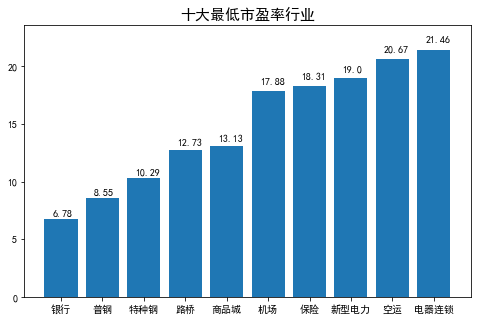

In [22]:
#查看十大最低市盈率行业
#这里行业划分不是很严谨，直接从数据库导出的
pe_ind=df.groupby('industry')['pe'].mean()
pe=pe_ind.sort_values()[:10].round(2)
title='十大最低市盈率行业'
plot_data(pe,title)

银行的市盈率是所有行业（这里行业分类比较细）里最低的，平均为6.78左右，其实不说你也知道：银行是中国上市公司里最赚钱的！但是，银行股可能因为盘子太大，短期走势就像心电图，所以散户一般是敬而远之。

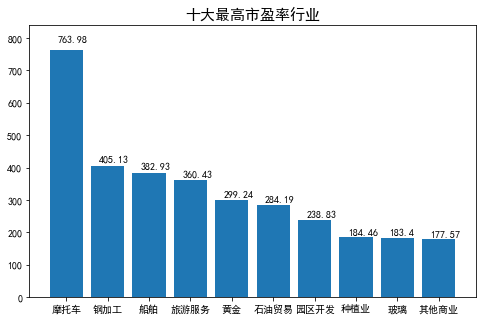

In [23]:
#查看十大最高市盈率行业
pe_ind1=df.groupby('industry')['pe'].mean()
pe1=pe_ind.sort_values(ascending=False)[:10].round(2)
title1='十大最高市盈率行业'
plot_data(pe1,title1)

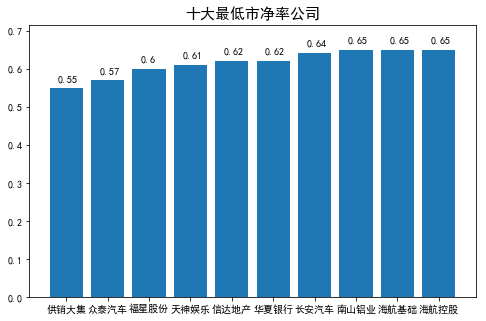

In [24]:
#查看十大最低市净率公司
pb=df['pb']
pb.index=df['name']
pb10=pb.sort_values(ascending=True)[:10].round(2)
title='十大最低市净率公司'
plot_data(pb10,title)

In [25]:
#查看市净率小于1的公司个数
n=df['pb'][df.pb<1].count()
print("市净率低于1公司个数：{:}".format(n))

市净率低于1公司个数：280


市净率是每股净资产与实时股价的比值，市净率小于1相当于公司以低于净资产的价格出售。一般而言，上市公司为了回避被隐性对手低价收购会尽力拉升股价。
但市净率小于1不一定就是好股票，还是要考察公司未来几年的业绩。市净率小于1的股票绝大多数会涨的，但股价弹性比较小，波动性也相对更小。

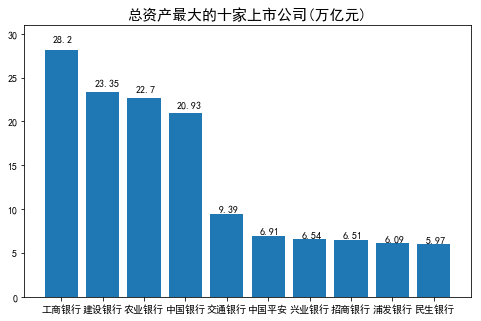

In [26]:
#查看总资产最大的十家上市公司（万亿元）
TA=(df['totalAssets']/10**8).round(2)
TA.index=df['name']
TA10=TA.sort_values(ascending=False)[:10]
title='总资产最大的十家上市公司(万亿元)'
plot_data(TA10,title)

In [27]:
icbc=(TA['工商银行']/TA.sum())*100
bank4=(TA[['工商银行','建设银行','农业银行','中国银行']].sum()/TA.sum())*100
print("工商银行资产占全部上市公司的比重为：{:.2f}%".format(icbc))
print("四大银行资产占全部上市公司的比重为：{:.2f}%".format(bank4))

工商银行资产占全部上市公司的比重为：12.07%
四大银行资产占全部上市公司的比重为：40.75%


总资产排名前十的都是银行（除平安是综合金融），而四大银行的资产规模庞大到惊人，工商银行总资产为28.2万亿元。

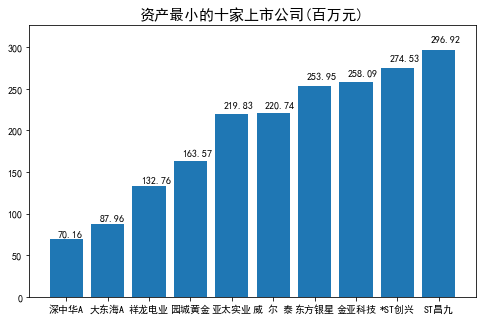

In [29]:
#再来看看总资产最小的十家上市公司（百万元）
TA1=(df['totalAssets']/100).round(2)
TA1.index=df['name']
TA2=TA1.sort_values(ascending=True)[:10]
title1='资产最小的十家上市公司(百万元)'
plot_data(TA2,title1)
#注意：这里是剔除了某些异常值后的数据结果

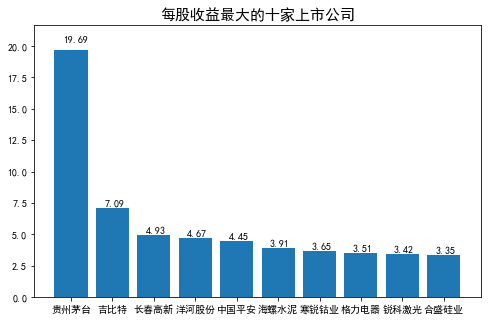

In [30]:
#每股收益最大的十家上市公司
esp=(df['esp'])
esp.index=df['name']
esp10=esp.sort_values(ascending=False)[:10]
title='每股收益最大的十家上市公司'
plot_data(esp10,title)
#贵州茅台一枝独秀，遥遥领先
#下面几家公司就是传说中的白马股啦
#白马股特征：长期绩优、回报率高并具有较高投资价值的股票

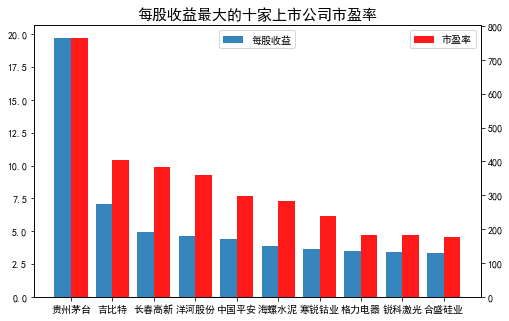

In [73]:
x0 = esp10.index   #横坐标
y = esp10.values   #第一个纵坐标
y1 =pe1.values   #第二个纵坐标
x = np.arange(len(x))  #首先用第一个的长度作为横坐标
width = 0.4    #设置柱与柱之间的宽度
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.bar(x,y,width,alpha = 0.9,label='每股收益')
plt.legend(loc='upper center')
ax2 = ax1.twinx()
ax2.bar(x+width,y1,width,alpha = 0.9,color= 'red',label='市盈率')
ax1.set_xticks(x +width/2)#将坐标设置在指定位置
ax1.set_xticklabels(x0)#将横坐标替换成
plt.legend(loc=0)
plt.title("每股收益最大的十家上市公司市盈率",fontsize=15)
plt.show()

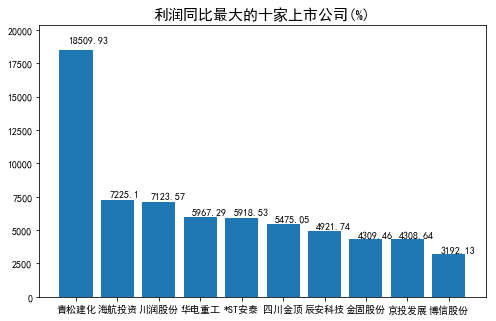

In [50]:
#利润同比最大的十家上市公司（%）
profit=(df['profit'])
profit.index=df['name']
profit10=profit.sort_values(ascending=False)[:10]
title='利润同比最大的十家上市公司(%)'
plot_data(profit10,title)

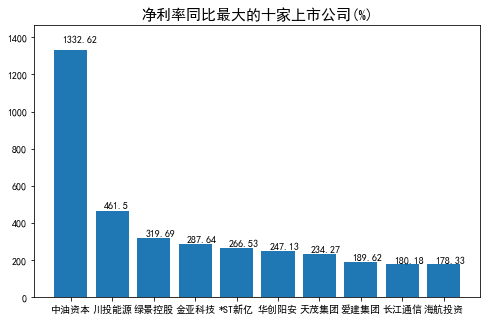

In [51]:
#净利率同比最大的十家上市公司（%）
npr=(df['npr'])
npr.index=df['name']
npr10=npr.sort_values(ascending=False)[:10]
title='净利率同比最大的十家上市公司(%)'
plot_data(npr10,title)